In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install --upgrade scikit-learn

In [2]:
# Remove Future Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# General
import numpy as np

# Data Management
import pandas as pd
from sklearn.model_selection import train_test_split

# Machine Learning
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

# Binary Classification Specific Metrics
from sklearn.metrics import RocCurveDisplay

# General Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Reporting
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from xgboost import plot_tree

### Data Management

In [5]:
# Data Extraction
df = pd.read_csv("/content/drive/MyDrive/ML_Trade/2_Supervised/data/AAPL.csv")
df.set_index("Date", inplace=True)
df.head(3)

,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets,RSI,RSI_Ret,...,MA_21,DOW,Roll_Rets,Avg_Range,Returns_T1,Range_T1,RSI_Ret_T1,Returns_T2,Range_T2,RSI_Ret_T2
Date,,,,,,,,,,,,,,,,,,,,,
2012-02-15 00:00:00-05:00,0.019023,0.032832,-0.010179,15.047397,2.271341,-0.023142,0.059168,0.404694,76.367817,0.848287,...,13.893777,2,0.194911,0.014668,0.013649,0.015060,1.011993,0.018605,0.013559,1.019394
2012-02-16 00:00:00-05:00,-0.044258,-0.040662,-0.020648,15.184668,-0.372857,0.009123,0.037523,0.420048,77.766635,1.018317,...,13.999026,3,0.198659,0.015479,-0.023142,0.059168,0.848287,0.013649,0.015060,1.011993
2012-02-17 00:00:00-05:00,0.023621,0.005704,0.028091,15.181941,-0.432741,-0.000180,0.014931,0.433254,77.668297,0.998735,...,14.106103,4,0.187377,0.015501,0.009123,0.037523,1.018317,-0.023142,0.059168,0.848287


In [6]:
# Specify Target
df.loc[df["Range"].shift(-1) > df["Avg_Range"], "TARGET"] = 1
df.loc[df["Range"].shift(-1) <= df["Avg_Range"], "TARGET"] = 0

In [7]:
# Fill NA
df["TARGET"].fillna(0, inplace=True)
df.tail()

,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets,RSI,RSI_Ret,...,DOW,Roll_Rets,Avg_Range,Returns_T1,Range_T1,RSI_Ret_T1,Returns_T2,Range_T2,RSI_Ret_T2,TARGET
Date,,,,,,,,,,,,,,,,,,,,,
2023-10-24 00:00:00-04:00,0.012521,-0.001954,0.008945,172.991058,-0.217283,0.002543,0.012948,62.642711,42.025233,1.033421,...,1,-0.014853,0.017912,0.000694,0.024010,1.008791,-0.014704,0.016103,0.880764,0.0
2023-10-25 00:00:00-04:00,-0.006761,-0.003512,-0.004666,170.657120,0.304460,-0.013492,0.014122,61.516190,37.151301,0.884024,...,2,-0.016490,0.017747,0.002543,0.012948,1.033421,0.000694,0.024010,1.008791,1.0
2023-10-26 00:00:00-04:00,-0.008785,-0.009708,-0.029183,166.458008,0.235637,-0.024606,0.034466,59.985252,30.334779,0.816520,...,3,-0.049878,0.018412,-0.013492,0.014122,0.884024,0.002543,0.012948,1.033421,0.0
2023-10-27 00:00:00-04:00,-0.020309,-0.014121,0.007002,167.784561,-0.171698,0.007969,0.012768,60.763601,34.427947,1.134933,...,4,-0.037754,0.018324,-0.024606,0.034466,0.816520,-0.013492,0.014122,0.884024,0.0
2023-10-30 00:00:00-04:00,0.012642,0.013080,0.012228,169.849197,-0.125952,0.012305,0.013620,61.178497,40.306545,1.170751,...,0,-0.042362,0.018170,0.007969,0.012768,1.134933,-0.024606,0.034466,0.816520,0.0


### Train Test Split

In [8]:
# Feature Selection
df_tts = df.copy()
df_tts = df_tts[["Returns", "Range", "RSI", "RSI_Ret", "Returns_T1", "RSI_Ret_T1", "TARGET"]]

In [9]:
# Split into X and Y Data
X = df_tts.iloc[:, : -1]
y = df_tts.iloc[:, -1]

In [10]:
# Perform Train Test Split (Timeseries based method)
train_size_rate = 0.7
train_size = int(len(X) * train_size_rate)
test_size = len(X) - train_size

X_train = X.head(train_size)
y_train = y.head(train_size)
X_test = X.tail(test_size)
y_test = y.tail(test_size)

size_check = len(y_test) + len(y_train) == len(X)
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)
print("Size Matches: ", size_check)

Shape of X_train:  (2062, 6)
Shape of y_train:  (2062,)
Shape of X_test:  (884, 6)
Shape of y_test:  (884,)
Size Matches:  True


### Build Model

In [11]:
# Select type of model to optimize for
is_binary = True
is_optimise_for_precision = True

In [12]:
# Determine Objective and Eval Metrics
if is_binary:
    objective = "binary:logistic"
    eval_metric = "logloss"
    eval_metric_list = ["error", "logloss", eval_metric]
else:
    objective = "multi:softmax"
    eval_metric = "mlogloss"
    eval_metric_list = ["merror", "mlogloss", eval_metric]

In [13]:
# Refine Eval Metric
if is_binary and is_optimise_for_precision:
    eval_metric = "aucpr"
    scoring = "precision"
elif is_binary and not is_optimise_for_precision:
    eval_metric = "auc"
    scoring = "f1"
else:
    scoring = "accuracy"

In [14]:
# Hyperparams: ne: 80, lr: 0.01 md: 3 gm: 6
ne = 150
lr = 0.01
md = 2
gm = 6

In [30]:
# XGBOOST Classifier
classifier = XGBClassifier(
    objective=objective,
    booster="gbtree",
    eval_metric=eval_metric_list,
    n_estimators=ne,
    learning_rate=lr,
    max_depth=md,
    gamma=gm,
    subsample=0.8,
    colsample_bytree=1,
    random_state=1,
    use_label_encoder=False
)

In [31]:
# Fit Model
eval_set = [(X_train, y_train), (X_test, y_test)]
classifier.fit(X_train, y_train, eval_set=eval_set, verbose=False)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=['error', 'logloss', 'logloss'], feature_types=None,
              gamma=6, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, random_state=1, ...)

### Make Predictions

In [32]:
# Get Predictions Training
train_yhat = classifier.predict(X_train)
train_yhat_proba = classifier.predict_proba(X_train)
print("Preds Training Data: \n", train_yhat[:10])
print("Preds Probabilities Training Data: \n", train_yhat_proba[:3])

Preds Training Data: 
 [1 0 0 0 0 0 0 0 0 0]
Preds Probabilities Training Data: 
 [[0.32007617 0.67992383]
 [0.5268138  0.4731862 ]
 [0.6446654  0.35533458]]


In [33]:
# Get Predictions Test
test_yhat = classifier.predict(X_test)
test_yhat_proba = classifier.predict_proba(X_test)
print("Preds Test Data: \n", test_yhat[:10])
print("Preds Probabilities Training Data: \n", test_yhat_proba[:3])

Preds Test Data: 
 [0 0 0 0 0 0 0 0 0 0]
Preds Probabilities Training Data: 
 [[0.52922773 0.47077227]
 [0.63944983 0.36055017]
 [0.64347243 0.35652757]]


In [34]:
# Set K-Fold Cross Validation Levels
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)

In [35]:
# Training Results
train_results = cross_val_score(classifier, X_train, y_train, scoring=scoring, cv=cv, n_jobs=1)

### Evaluation Metrics  - Loss and Overfitting

In [38]:
# Retrieve performance metrics
results = classifier.evals_result()
epochs = len(results["validation_0"]["error"])
x_axis = range(0, epochs)

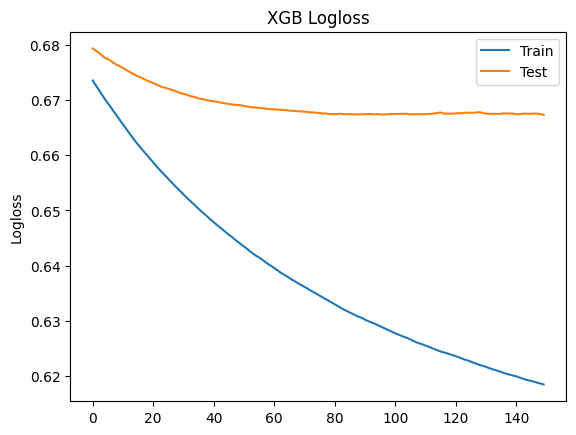

In [39]:
# Plot Log Loss
fig, ax = plt.subplots()
ax.plot(x_axis, results["validation_0"]["logloss"], label="Train")
ax.plot(x_axis, results["validation_1"]["logloss"], label="Test")
ax.legend()
plt.ylabel("Logloss")
plt.title("XGB Logloss")
plt.show()

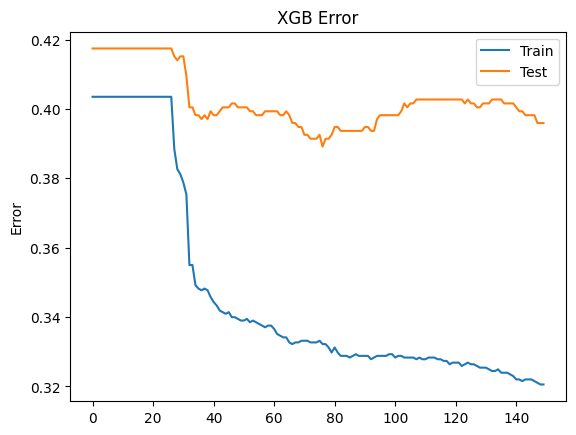

In [40]:
# Plot Classification Error
fig, ax = plt.subplots()
ax.plot(x_axis, results["validation_0"]["error"], label="Train")
ax.plot(x_axis, results["validation_1"]["error"], label="Test")
ax.legend()
plt.ylabel("Error")
plt.title("XGB Error")
plt.show()

### Evaluation Metrics - ROC Curve

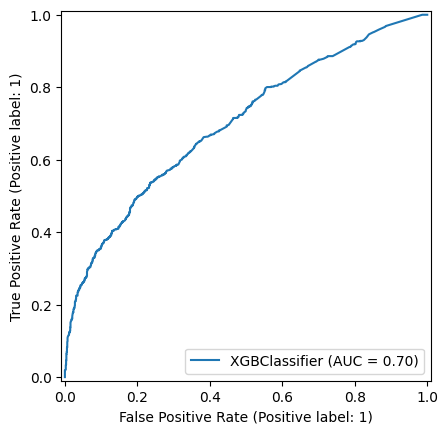

In [41]:
# Plot Training ROC Curve
RocCurveDisplay.from_estimator(classifier, X_train, y_train)

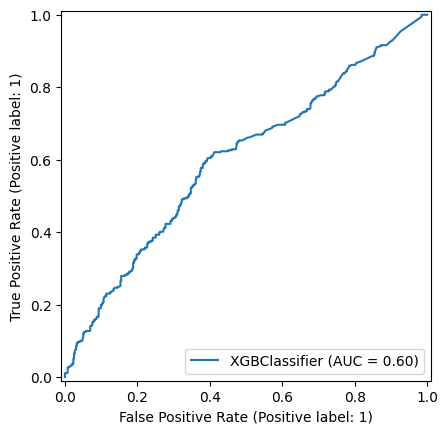

In [42]:
# Plot Test ROC Curve
RocCurveDisplay.from_estimator(classifier, X_test, y_test)

### Performance Evaluation Comparison

In [43]:
# Set K-Fold Cross Validation Levels
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)

In [44]:
# Training and Test Results
train_results = cross_val_score(classifier, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
test_results = cross_val_score(classifier, X_test, y_test, scoring=scoring, cv=cv, n_jobs=-1)

In [45]:
# Comparison of Results
print("TRAIN:")
print("Average Acc K-Fold", round(train_results.mean(), 2))
print("Std Dev K-Fold", round(train_results.std(), 2))
print("Precision Score 0", round(precision_score(y_train, train_yhat, average=None)[0], 3))
print("Precision Score 1", round(precision_score(y_train, train_yhat, average=None)[1], 3))
print("----- ----- ----- ----- ----- ----- -----")
print("TEST:")
print("Average Acc K-Fold", round(test_results.mean(), 2))
print("Std Dev K-Fold", round(test_results.std(), 2))
print("Precision Score 0", round(precision_score(y_test, test_yhat, average=None)[0], 3))
print("Precision Score 1", round(precision_score(y_test, test_yhat, average=None)[1], 3))
print("")

TRAIN:
Average Acc K-Fold 0.69
Std Dev K-Fold 0.05
Precision Score 0 0.664
Precision Score 1 0.76
----- ----- ----- ----- ----- ----- -----
TEST:
Average Acc K-Fold 0.58
Std Dev K-Fold 0.1
Precision Score 0 0.617
Precision Score 1 0.554



### Evaluation Metrics - Summary Report

In [46]:
# Show summary report - Training
print(classification_report(y_train, train_yhat))

              precision    recall  f1-score   support

         0.0       0.66      0.94      0.78      1230
         1.0       0.76      0.30      0.43       832

    accuracy                           0.68      2062
   macro avg       0.71      0.62      0.60      2062
weighted avg       0.70      0.68      0.64      2062



In [47]:
# Show summary report - Test
print(classification_report(y_test, test_yhat))

              precision    recall  f1-score   support

         0.0       0.62      0.85      0.71       515
         1.0       0.55      0.27      0.36       369

    accuracy                           0.60       884
   macro avg       0.59      0.56      0.54       884
weighted avg       0.59      0.60      0.57       884



### Performance Evaluation - Confusion Matrix

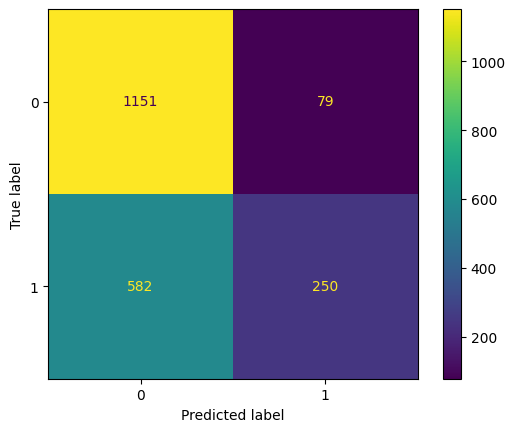

In [48]:
# Training Confusion Matrix
cm_train = confusion_matrix(y_train, train_yhat)
ConfusionMatrixDisplay(cm_train).plot()

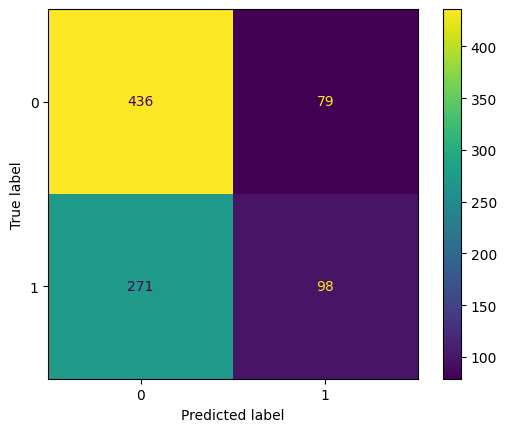

In [49]:
# Test Confusion Matrix
cm_test = confusion_matrix(y_test, test_yhat)
ConfusionMatrixDisplay(cm_test).plot()

### Feature Importance

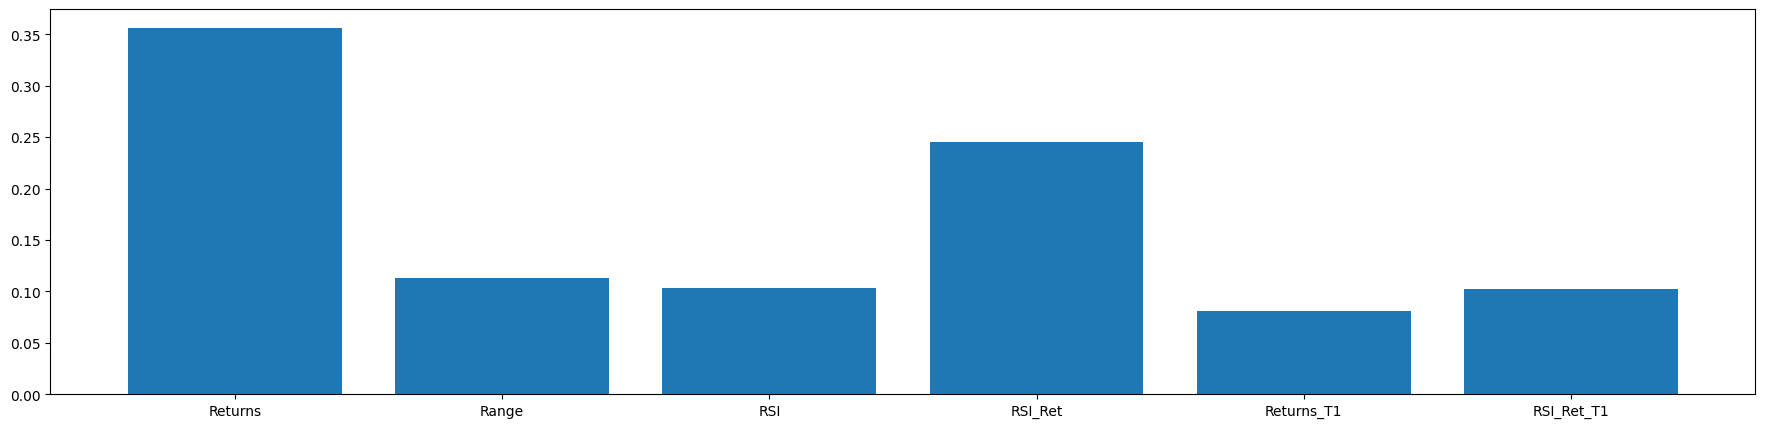

In [50]:
# Plot Feature Importances
fig = plt.figure(figsize=(22, 5))
importance_labels = X.columns
importance_features = classifier.feature_importances_
plt.bar(importance_labels, importance_features)
plt.show()

### XGBOOST TREE

<Axes: >

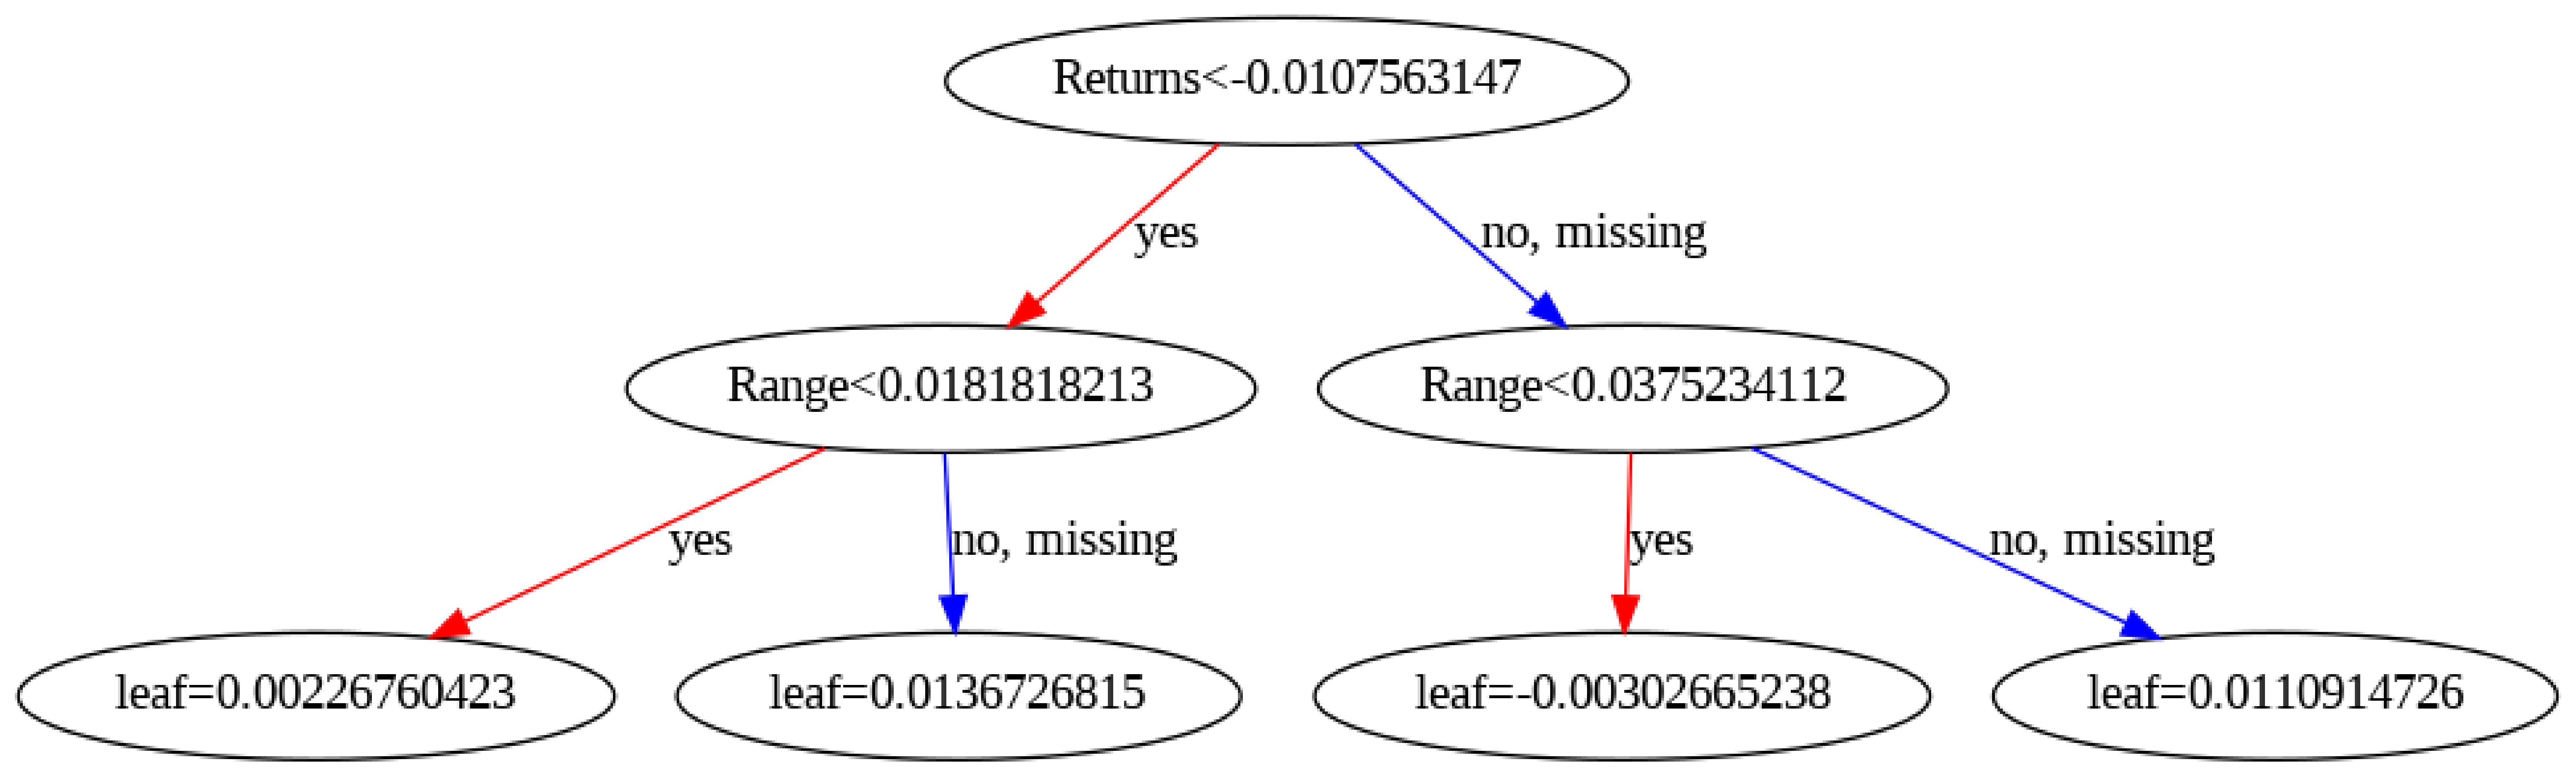

In [51]:
rcParams["figure.figsize"] = 80, 50
plot_tree(classifier)